# Extended Graham scan algorithm

Use the cell below for all python code needed to realise the extended Graham scan algorithm (including any auxiliary data structures and functions you might need). The `extendedgrahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [4]:
import math

'''
References:
Wikipedia: https://en.wikipedia.org/wiki/Graham_scan
dummies.com: https://www.dummies.com/education/math/algebra/finding-the-area-of-a-triangle-using-its-coordinates/#:~:text=The%20first%20formula%20most%20encounter,base)%20drawn%20from%20that%20side.
A Preprocessing Technique for Fast Convex Hull Computation: https://doi.org/10.1016/j.procs.2020.03.046
'''

def changerange(theta):
    '''
    This function changes the range of the angle from [-pi, pi) to [0, 2pi), 
    since the paper uses the range [0, 2pi) and the math library uses [-pi, pi)
    ''' 
    return theta if theta >= 0 else math.tau + theta

def ccw(p1, p2, p3):
    ''' 
    Calculates the z-component using the Cross Product Formula.
    If the result is  0 -> The 3 points are collinear.
    If the result is >0 -> The 3 points constitute a counter-clockwise orientation.
    If the result is <0 -> The 3 points constitute a clockwise orientation.
    If either of the point is invalid then it must be true that the points that are valid is collinear.
    '''
    if p1 == None or p2 == None or p3 == None:
        return 0
    return (p2[0]-p1[0])*(p3[1]-p1[1])-(p2[1]-p1[1])*(p3[0]-p1[0])

def pyth(p1, p2=[0,0]):
    '''  Calculates the distance between two points in the R^2 vector space using Pythagorous' '''
    return sum([(p1[i] - p2[i]) ** 2 for i in range(len(p1))]) ** 0.5

def calcP(inputSet):
    ''' Reference to Wikipedia for this function.  This function seeks the lowest y-coordinate and leftmost point. '''
    P = inputSet[0]
    for point in inputSet:
        if point[1] < P[1] or (point[1] == P[1] and point[0] < P[0]):
            P = point
    return P

def cartesianList(polarHull, P):
    ''' Converts a list of Polar Coordinates to Cartesian Coordinates and changes the Origin from P to (0, 0) '''
    return [cartesian(i, P=P) for i in polarHull]

def resetOrigin(P, inputSet):
    ''' Changes the Origin of the Points from (0, 0) to P, and Converts Cartesian Coordinates to Polar '''
    return [polar([i[0]-P[0], i[1]-P[1]]) for i in inputSet]

def polar(coordinates):
    ''' Converts a Cartesian Coordinate to a Polar Coordinate '''
    return [pyth(coordinates), changerange(math.atan2(coordinates[1], coordinates[0]))]

def cartesian(coordinates, P=[0,0]):
    ''' Converts a Polar Coordinate to Cartesian Coordinate '''
    return [round((coordinates[0] * math.cos(coordinates[1])) + P[0]), round((coordinates[0] * math.sin(coordinates[1])) + P[1])]

def merge(L,R):
    ''' Implements the Merge Sort Algorithm '''
    ret_array = []
    l_index, r_index = 0, 0
    while len(ret_array) < (len(L) + len(R)):
        if l_index == len(L):
            ret_array += R[r_index::]
            break
        elif r_index == len(R):
            ret_array += L[l_index::]
            break
        if L[l_index][1] < R[r_index][1]:
            ret_array.append(L[l_index])
            l_index += 1
        elif L[l_index][1] >= R[r_index][1]:
            ret_array.append(R[r_index])
            r_index += 1
    return ret_array

def msort(inputSet):
    ''' Implements the Merge Sort Algorithm, Sorts the List of Coordinate by their Radian Angle '''
    return inputSet if len(inputSet) == 1 else merge(msort(inputSet[:len(inputSet)//2:]), msort(inputSet[len(inputSet)//2::]))

def maxr(inputSet, threshold=1e-8):
    '''
    This function selects the polar coordinate with same angle as others but has the largest magnitude
    A threshold default argument has been added to prevent floating point arithmetic errors
    '''
    polar, curtheta = [], -float("inf")
    for i in inputSet:
        if abs(i[1] - curtheta) < threshold:
            polar[-1][0] = max(i[0], polar[-1][0])
        else:
            polar.append(i)
            curtheta = i[1]
    return polar

def deletenomag(inputSet):
    ''' This function removes the polar coordinates with no magnitude '''
    return [i for i in inputSet if i[0] != 0]

def trace(inputSet, P):
    ''' Traces the Graham Scan Convex Hull.  This Algorithm is inspired by Wikipedia's Pseudocode and YouTube '''
    stack = [P, inputSet[0]]
    for point in inputSet[1::]:
        while ccw(stack[-2], stack[-1], point) < 0:
            _ = stack.pop()
        stack.append(point)
    return stack

def enclosedCoords(inputSet):
    ''' Calculates the four margins where the points inside the margin can definitely not be in the convex hull subset '''
    xmax, xmin = [-float("inf"),0], [float("inf"),0]
    ymax, ymin = [0,-float("inf")], [0,float("inf")]
    for coord in inputSet:
        xmax = coord if max(coord[0],xmax[0]) == coord[0] else xmax
        xmin = coord if min(coord[0],xmin[0]) == coord[0] else xmin
        ymax = coord if max(coord[1],ymax[1]) == coord[1] else ymax
        ymin = coord if min(coord[1],ymin[1]) == coord[1] else ymin
    return [xmax,ymax,xmin,ymin]

def triangleArea(point1, point2,point3):
    ''' Using the Determinents of a Matrix to calculate the Triangle's Area.  Refer to dummies.com '''
    return abs(point1[0]*(point2[1]-point3[1]) + point2[0]*(point3[1]-point1[1]) + point3[0]*(point1[1]-point2[1])) /2

def notinRegion(point,enclose,area):
    ''' Finds whether if a specific point is in the enclosed area.  Returns true if the point is not in the enclosed area. '''
    total = [triangleArea(enclose[0],enclose[1],point), triangleArea(enclose[1],enclose[2],point), triangleArea(enclose[2],enclose[3],point), triangleArea(enclose[3],enclose[0],point)]
    return (sum(total) != area)

def wipePoints(inputSet):
    ''' Remove points within inputSet that are enclosed by the NorthWest, NorthEast, SouthWest, SouthEast points '''
    points = enclosedCoords(inputSet)
    enclosedArea = triangleArea(points[0],points[1],points[2]) + triangleArea(points[2],points[3],points[0])
    return [p for p in inputSet if notinRegion(p,points,enclosedArea)] + points

def extendedgrahamscan(inputSet):
    '''
    This Graham Scan function takes in the set of coordinates and returns a subset of the input which is the convex hull.
    The function first calculates P, changes the origin of the coordinates and converts the points to polar.
    It then removes the polar coordinates with no magnitude and then sorts the points by their angle.  This has been done
    explicitly to reduce the amount of datapoints that will need to be sorted.
    After the list has been sorted it removes the points with the same angle but a smaller magnitude than others.  It then 
    converts everything back into a list of Cartesian Coordinates and traces the Convex Hull.
    '''
    inputSet = wipePoints(inputSet)
    P = calcP(inputSet)
    polarSet = cartesianList(maxr(msort(deletenomag(resetOrigin(P, inputSet)))), P)
    return trace(polarSet, P)

Use the cell below for all python code needed to generate test data points (both random and those representing worst-case scenario).

In [5]:
import random

def alternate(inputSet):
    #Alternates element within a sorted array, making mergesort doing the most comparisons
    retArray = [[],[]]
    if len(inputSet) == 2:
        retArray[0] = [inputSet[0]]
        retArray[1] = [inputSet[1]]
    else:
        i = 0
        while i*2< len(inputSet):
            #Splitting into left array and right array
            retArray[0].append(inputSet[i * 2])
            if (i * 2 + 1 < len(inputSet)):
                retArray[1].append(inputSet[i*2 + 1])
            i += 1
    return retArray

def genWorstDataSet(inputSet):
    #Generate worst dataset using recursion
    if len(inputSet) == 1:
        return inputSet
    splitArray = alternate(inputSet)
    left = genWorstDataSet(splitArray[0])
    right = genWorstDataSet(splitArray[1])
    return (left + right)

def sortsecondIndex(arr):
    #Generate array of sorted indexes that corresponds to the datapoints within worst dataset
    secondElement = [f[1] for f in arr] #Array sorted using the polar angles
    return sorted(range(len(arr)),key = lambda k : secondElement[k])

def changetoIndex(arr,indexArr):
    #Modify original xy coordinate dataset according to the sorted index array
    retArr = [None for i in range (len(arr))]
    x = 0
    for count,index in enumerate(indexArr):
        retArr[count] = arr[index]
    return retArr

def randGeneration(n, lb=0, ub=32767):
    ''' Code for Random Data Generation '''
    return [[random.randint(lb, ub), random.randint(lb, ub)] for i in range(n)]

def randWorstGeneration(dataset):
    ''' Code for Worst Case Data Generation '''
    P = calcP(dataset)
    #Sort secondIndex computed upon polar form of the dataset
    sortedIndex = sortsecondIndex(resetOrigin(P, dataset))
    #changetoIndex returns the worst case dataset in xy coordinates form
    sortedArray = changetoIndex(dataset,sortedIndex)
    return genWorstDataSet(sortedArray)

Use the cell below for all python code needed to test the `extendedgrahamscan()` function on the data generated above.

In [6]:
import timeit

def test(n, repeats=1):
    ''' 
    Takes in a list of n and returns two lists of times (the average and worst case)
    where the each time is in seconds and is an average of repeated runs of the same algorithm.
    '''
    randtimetaken, worsttimetaken = [0 for i in range(len(n))], [0 for i in range(len(n))]
    for j in range(repeats):
        for i in n:
            randdata = randGeneration(int(i))
            worstdata = randWorstGeneration(randdata)
            start_time = timeit.default_timer()
            _ = extendedgrahamscan(randdata)
            randtimetaken[n.index(i)] += timeit.default_timer() - start_time
            start_time = timeit.default_timer()
            _ = extendedgrahamscan(worstdata)
            worsttimetaken[n.index(i)] += timeit.default_timer() - start_time
    return [i/repeats for i in randtimetaken],[i/repeats for i in worsttimetaken]

n = [500*(i+1) for i in range(40)]
r_timetaken, w_timetaken = test(n, repeats=5)

[0.0023885600000028264, 0.005184980000004202, 0.00795332000000144, 0.01058751999999714, 0.011890900000001637, 0.01586201999999872, 0.020774199999996766, 0.020012980000004177, 0.023710299999999053, 0.02636597999999992, 0.03050943999999589, 0.03315251999999873, 0.03426078000000103, 0.04073388000000193, 0.0377647200000041, 0.04257564000000258, 0.04843386000000009, 0.049662359999996394, 0.0538934600000033, 0.05794816000000367, 0.05723296000000033, 0.07188421999999832, 0.05945581999999945, 0.06953725999999989, 0.06742363999999981, 0.0704169599999986, 0.06918244000000015, 0.07765673999999478, 0.0822818199999972, 0.08570265999999549, 0.08997938000000119, 0.08812210000000249, 0.10027955999999846, 0.10302676000000162, 0.0960334999999958, 0.1130530400000012, 0.10814530000000104, 0.10437827999999741, 0.09982164000000182, 0.12293668000000083]


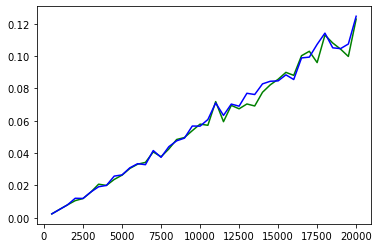

In [7]:
import matplotlib.pyplot as plt
print (r_timetaken)
plt.plot(n,r_timetaken,color = 'green')
plt.plot(n,w_timetaken,color = 'blue')
plt.show()

*Optional*: Feel free to use the code below on small datasets (e.g., N = 10) to visually inspect whether the algorithm has been implemented correctly. The fragment below assumes both `inputSet` and `outputSet` to be lists of 2D points, with each point being a list of 2 elements (e.g., `[[x1,y1], [x2,y2], ..., [x_k,y_k]]`)

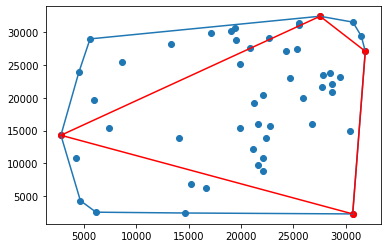

In [10]:
import matplotlib.pyplot as plt

#inputSet = [[1,1], [2,2], [3,3], [4,4], [1,4], [3,1], [1,5], [2,4], [3,5]]
#outputSet = [[1,1], [3,1], [4,4], [3,5], [1,5]]

inputSet = randGeneration(50)
outputSet = extendedgrahamscan(inputSet)
plt.figure()

#first do a scatter plot of the inputSet
input_xs, input_ys = zip(*inputSet)
plt.scatter(input_xs, input_ys)

bound = enclosedCoords(inputSet)
bound_xs, bound_ys = zip(*bound)
plt.scatter(bound_xs, bound_ys,color = "red")

#then do a polygon plot of the computed covex hull
outputSet.append(outputSet[0]) #first create a 'closed loop' by adding the first point at the end of the list
output_xs, output_ys = zip(*outputSet)
plt.plot(output_xs, output_ys) 

bound.append(bound[0])
output_xs, output_ys = zip(*bound)
plt.plot(output_xs, output_ys,color = "red") 


plt.show() 
